In [4]:
from PIL import Image
import os, random, re
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import transforms
import pickle
import json
import torch
from typing import List, Tuple
from pprint import pprint

COLORS = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
         '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
         '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
         '#000075', '#808080', '#000000']

## Funcstions
  - functons to find positive CoM chains
  - funcstions to visualize CoM chains for each image sample stored in .jsonl file

In [5]:
class Node:
    def __init__(self, data, key):
        self.key = key
        self.data = data

def build_tree(dict_tree):
    dtree = {}
    max_depth = 0
    for k,v in dict_tree.items():
        k = k.replace('*', '~')
        dtree[k] = v
        max_depth  = (k.split('--')[1].split(',')[0])

    tree = {}
    for key in sorted(dtree.keys()):
        fid, curid = key.split('--')
        flevel, ford = fid.split(',')
        clevel, cord = curid.split(',')
        if ford == '~':
            for i in range(1000): # maximum
                fid = f'{flevel},{i}'
                if fid not in tree:
                    if fid.split(',')[0] == '-1' and i==0: # one root
                        tree[fid] = [Node(dtree[key], key)]
                        if clevel != max_depth:
                            tree[curid] = [] # add current node !
                    break
                tree[fid].append(Node(dtree[key], key))
                if clevel != max_depth:
                    tree[curid] = []
        else:
            tree[fid] = tree.get(fid, []) + [Node(dtree[key], key)]
            if clevel != max_depth:
                tree[curid] = []
    return tree


def find_paths(tree):
    paths = []
    level = 0
    path = []
    def dfs(node):
        nonlocal tree, path
        fid, curid = node.key.split('--')
        path.append(node)
        if 'found' in node.data and node.data['found']:
            # paths.append([n.data['found'] for n in path])
            paths.append([n.data for n in path])
        if curid in tree:
            for child in tree[curid]:
                dfs(child)
        path.pop()
    # for root in tree[0]:
    for root in tree.get('-1,0', []):
        dfs(root)
    return paths

In [6]:
# add captions
def draw_text(ax, x, y, text, color, transform):
    text = ax.text(x,y,text,color=color, transform=transform)
    text.draw(ax.figure.canvas.get_renderer())
    ex = text.get_window_extent()
    t = transforms.offset_copy(text._transform, x=ex.width, units='dots')
    return t, ex

In [7]:
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

def visualize_com(ann, save_name=None, print_label=True):
    """ The ann contains image_path, questions, answers and corresponding grounding information. """
    img = ann['image_path']
    QAs = ann['metadata']
    img_ann = ann.get('image_ann', None)
    print(f"image_path: {img}")
    
    # 1. 构建一个全局的 variables 字典
    all_variables = {}  # 用来存储所有 param 和对应的 variables

    for qa in QAs:
        if not qa.get('final_com', None):
            continue

        # 遍历 final_com，提取所有的 variables
        for key, com in qa['final_com'].items():
            variables = com.get('variables', {})
            for vk, vv in variables.items():
                all_variables[vk] = vv  # 将 variables 加入到全局字典

    # 打印检查字典内容
    print(f"All variables: {all_variables}")
    
    for qa in QAs:
        if not qa.get('final_com', None):
            continue

        tree = build_tree(qa['final_com'])
        chains = find_paths(tree)
        if len(chains) == 0:
            continue

        print(f"Q: {qa['question']}")
        print(f"A: {qa['answer']}")

        pil_img = Image.open(img)
        max_len = max([len(c) for c in chains])
        fig, axes = plt.subplots(len(chains), max(2, max_len), figsize=(18, 4))
        axes = [axes] if len(chains) == 1 else axes
        boxid, phr2boxid = 0, {}
        
        for i, chain in enumerate(chains):
            print(f"------ chain {i} -------")
            for ii, com in enumerate(chain):
                func, param, variables, desc = com['func'], com['param'], com['variables'], com['desc']
                
                if variables:
                    for iii, (vk, vv) in enumerate(variables.items()):
                        boxid += iii
                        # boxx
                        if 'bbx' in vk:
                            if isinstance(vv, list) and (isinstance(vv[0], int) or isinstance(vv[0], float)):
                                vv = [vv]
                            elif isinstance(vv, list) and isinstance(vv[0], list):
                                vv = vv
                            for box in vv:
                                axes[i][ii].add_patch(Rectangle(
                                    (box[0], box[1]),
                                    box[2] - box[0],
                                    box[3] - box[1],
                                    fill=False,
                                    edgecolor=COLORS[boxid % len(COLORS)],
                                ))
                                axes[i][ii].text(box[0], box[1],
                                                 "{}".format(param),
                                                 bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 2},
                                                 style='italic',
                                                 color=COLORS[boxid % len(COLORS)])
                                phr2boxid[param] = boxid
                
                # crop
                """
                Crop the image based on the provided bounding box.

                Args:
                    pil_img (Image.Image): The PIL image to be cropped.
                    crop_box (Tuple[int, int, int, int]): The bounding box for cropping in the format (x1, y1, x2, y2).

                Returns:
                    Image.Image: The cropped PIL image.
                """

                if func and 'crop' in func.lower():
                    crop_box = com["onbox"]
                    pil_img = pil_img.crop(crop_box)
                    print(f"Cropped image: {crop_box}")

                # line
                """
                Draw a line on the given Matplotlib Axes based on the provided parameters.

                Args:
                    ax (plt.Axes): The Matplotlib Axes object to draw the line on.
                    param (str): The line parameters in the format "[x1, y1, x2, y2], a, b".
                    boxid (int): Identifier for selecting color from the COLORS list.
                    COLORS (List[str]): List of available colors.

                Returns:
                    None
                """
                
                if func and 'line' in func.lower():
                    print(param)
                    match = re.match(r'\[\s*([\d,\s]+)\s*\],\s*(\d+),\s*(\d+)', param)
                    if match:
                        try:
                            line_coords = list(map(int, match.group(1).split(',')))
                            a, b = int(match.group(2)), int(match.group(3))
                            
                            if len(line_coords) != 4:
                                raise ValueError(f"Invalid number of coordinates: {line_coords}")
                            
                            x1, y1, x2, y2 = line_coords
                            points = {
                                1: (x1, y1),
                                2: (x2, y1),
                                3: (x2, y2),
                                4: (x1, y2)
                            }
                            
                            if a not in points or b not in points:
                                raise ValueError(f"Invalid point indices: a={a}, b={b}")
                            
                            start, end = points[a], points[b]
                            axes[i][ii].plot(
                                [start[0], end[0]],
                                [start[1], end[1]],
                                color=COLORS[boxid % len(COLORS)],
                                linewidth=2,
                                linestyle="dashed"
                            )
                        except ValueError as e:
                            print(f"Error processing line parameters '{param}': {e}")
                    else:
                        print(f"Parameter format mismatch: {param}")
                        

                axes[i][ii].text(-8, pil_img.size[1], desc, ha='left', rotation=90, wrap=True)
                print(desc)

                # Text and annotations
                x, y = 0, pil_img.size[1] + 30
                if print_label:
                    pre_words, phrase, post_words = desc, "", ""
                    for phr in phr2boxid:
                        pos = desc.find(phr)
                        if pos != -1:
                            phrase, ph_s, ph_e = desc[pos: pos+len(phr)], pos, pos+len(phr)
                            pre_words, post_words = desc[:ph_s], desc[ph_e:]
                        t = axes[i][ii].transData
                        t, ex = draw_text(axes[i][ii], x, y, pre_words + ' ', "#000000", t, plt.gca().transData)
                        if phrase:
                            t, ex = draw_text(axes[i][ii], x, y, phrase + '', COLORS[phr2boxid[phrase] % len(COLORS)], t, plt.gca().transData)
                            t, ex = draw_text(axes[i][ii], x, y, post_words, "#000000", t, plt.gca().transData)
                        y += ex.height + 15

                axes[i][ii].axes.xaxis.set_visible(False)
                axes[i][ii].axes.yaxis.set_visible(False)
                axes[i][ii].tick_params(labelbottom='off', labelleft='off')
                axes[i][ii].imshow(pil_img)

    plt.show()

    if save_name:
        fig.savefig(save_name)


image_path: images/ST-VQA/VisualGenome_2_2403361.jpg
All variables: {'bbx_1': [[142, 127, 296, 431]], 'img_1': None, 'txt_1': 'white'}
Q: What color is the woman's visor?
A: white
------ chain 0 -------
Based on GROUNDING(the woman's visor) to identify the woman's visor in the image, and the result is `bbx_1`.
Crop operation: bbx_1
Cropped image: 142, 127, 296, 431
Using CROP_AND_ZOOMIN(bbx_1) to crop the image using the bounding box `bbx_1`, and zoom in the cropped image by two times to get `img_1`.
Leveraging OCR(the color of the visor in image `img_1`) to recognize the color of the visor in the image `img_1`, and the result is `txt_1`.


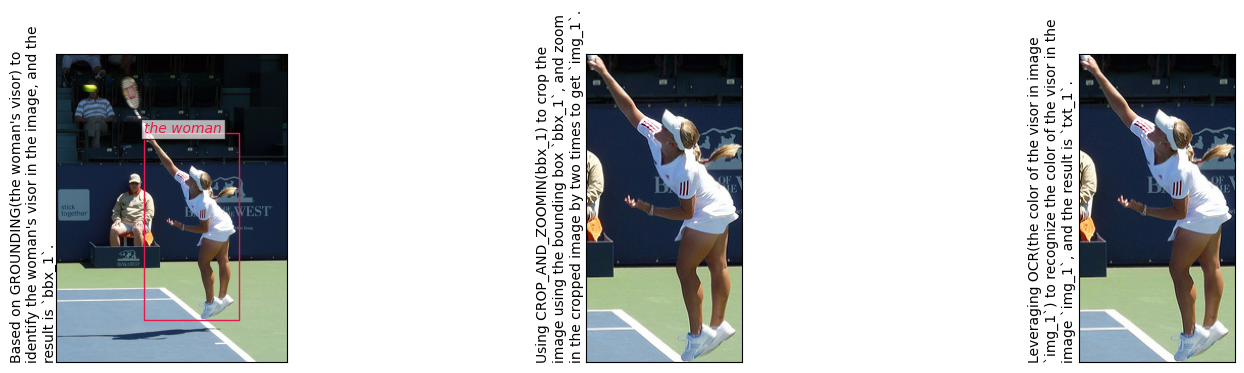

In [58]:
# view com_math
data = []
with open('com.jsonl') as f:
    for line in f:
        data.append(json.loads(line))

# visualize
visualize_com(data[], print_label=False, save_name='eg_commath3.png')
# visualize_com(data[20], print_label=False, save_name='eg_commath20.png')

# Visualize
  - specify jsonl file (e.g., com_math.jsonl)

image_path: images/MathVista/images_683.jpg
All variables: {'img_1': 'img_1', 'img_2': 'img_2', 'bbx_2': [16, 81, 430, 143], 'bbx_1': [16, 81, 430, 143]}
Q: Move the ruler to measure the length of the nail to the nearest inch. The nail is about (_) inches long.
A: 2
------ chain 0 -------
[69, 0, 75, 157],1,4
Draw the leftmost vertical Line of the nail with LINE([69, 0, 75, 157],1,4)->img_1, to obtain a new image `img_1` after drawing the line.
[197, 6, 203, 157],2,3
Draw the the rightmost vertical Line of the nail with LINE([197, 6, 203, 157],2,3)->img_2, to obtain a new image `img_2` after drawing the line.
Based on GROUNDING(ruler scale), locate the scale of the ruler in the image, the position is `bbx_2`.
The length of the nail is about 2 inches, so the answer is 2.


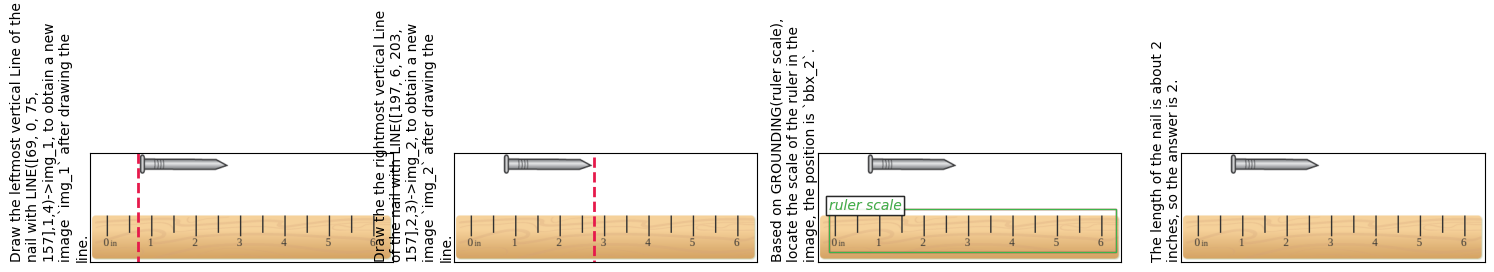

In [9]:
# view com_math
data = []
with open('com_math.jsonl') as f:
    for line in f:
        data.append(json.loads(line))

# visualize
visualize_com(data[1], print_label=False, save_name='eg_commath3.png')
# visualize_com(data[20], print_label=False, save_name='eg_commath20.png')

In [6]:
import json

def filter_crop_and_zoom_in_entries(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    result = []
    for line in lines:
        try:
            entry = json.loads(line)
            # 遍历 metadata 中的 final_com 字段，查找 func 字段包含 "crop_and_zoom_in"
            for metadata in entry.get('metadata', []):
                for key, value in metadata.get('final_com', {}).items():
                    if isinstance(value, dict):
                        func = value.get('func')
                        # 确保 func 存在且不是 None，并且包含 "crop_and_zoom_in"
                        if func and 'crop_and_zoom_in' in func:
                            result.append(value)
        except json.JSONDecodeError as e:
            print(f"Error decoding line: {e}")
        except TypeError as e:
            print(f"Error processing line: {e}")
    
    return result

# 文件路径
file_path = '/mnt/petrelfs/share_data/suzhaochen/cogcom/com_math.jsonl'

# 获取所有符合条件的条目
filtered_entries = filter_crop_and_zoom_in_entries(file_path)

# 输出结果
for entry in filtered_entries:
    print(json.dumps(entry))


{"func": "crop_and_zoom_in", "param": "2", "onbox": null, "variables": {}, "return": "img1", "desc": "Since the direction of the small arrow is not clear, based on the crop_and_zoom_in(`bbx_1`, 2), the area where the pointer is located is cropped and enlarged by 2 times to obtain a new image img1, and then observe img1.", "found": false}
{"func": "crop_and_zoom_in_1", "param": "text", "onbox": [163, 448, 261, 507], "variables": {"bbx_1": [163, 448, 261, 507], "img_1": "img_1"}, "return": "img_1", "desc": "Use CROP_AND_ZOOMIN(box `bbx_1`)->img_1 to zoom in on the position of the text to the left below the two pillars in the image by two times, obtaining image `img_1`, and observe `img_1`.", "found": false}
{"func": "crop_and_zoom_in_2", "param": null, "onbox": [583, 446, 683, 501], "variables": {"bbx_2": [583, 446, 683, 501], "img_2": "img_2"}, "return": null, "desc": "Use CROP_AND_ZOOMIN(box `bbx_2`)->img_2 to double the size of the text on the right below the two pillars in the image,

In [7]:
# 文件路径
file_path = '/mnt/petrelfs/share_data/suzhaochen/cogcom/com.jsonl'

# 获取所有符合条件的条目
filtered_entries = filter_crop_and_zoom_in_entries(file_path)

# 输出结果
for entry in filtered_entries:
    print(json.dumps(entry))